# SubChallenge 1 write up

This jupyter notebook explains the approach that was taken to solve the SubChallenge 1. 

For SubChallenge 1 we used Kernel Ridge Regression to predict the amount of the IC50 values for the isolates. Before, that the important genes, meaning the genes that are biologically related to artemisinin resistant, were identified and used as features.


In summary these are the steps that were taken:

1. Find important genes
2. Flatten the train data
3. Find genes that generete the best model
4. Train the model with all the isolates and the selected genes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib import colors
import numpy as np
import operator
from sklearn.kernel_ridge import KernelRidge

## 1. Import libraries and datasets

In [2]:
GO=pd.read_csv('../data/GO_Processes_In_Resistance.csv')
PF_genes=pd.read_csv('../data/PFalciparum_Gene_GOterms.csv')
train=pd.read_csv('../data/SubCh1_TrainingData.csv')
test=pd.read_csv('../data/flat_test.csv',index_col=0)
IC50=pd.read_csv('../data/flat_IC50.csv',index_col=0)
genes_column_labels_df=pd.read_csv('../data/genes_column_labels.csv')
isolates_test=[line.rstrip('\n') for line in open('../data/isolates_test.txt')]

## 2. Find important genes

### 2.1 Identify GO processes involved in artemisin resistance

After reviewing the literature suggested for the SubChallenge1, we manually listed the biological processes that have been found to be resistant to artemisin. Later, we match these processes to the columns **Go Process ID** and **Go Process Desc** of the **PFalciparum_Gene_GOterms** (from now on PF_genes data frame) and created the **GO** data frame to which we added a column specifying with 1 that the process is "important" for artemisin resistance and with 0 that it is "not important".

In [3]:
GO.head()

,GO Process ID,GO Process Desc,IsInvolvedInArtemisinResistance
0,GO:0020033,antigenic variation,0
1,GO:0098609,cell-cell adhesion,1
2,GO:0020035,"cytoadherence to microvasculature, mediated by...",1
3,GO:0020013,modulation by symbiont of host erythrocyte agg...,1
4,GO:0042000,translocation of peptides or proteins into host,0


### 2.2 Identify genes involved in aremisin resistance "Important genes"

From the **PF_genes** dataframe, we extracted the genes that are related to each GO Process of the **GO_initial** dataframe and added them as a new column Gene_ID. We also added the column Gene_Count.

In [4]:
Gene_to_Go_Process_df=pd.DataFrame({'Gene_ID':PF_genes['Gene ID'],\
                                               'Curated_Go_Process_IDs':PF_genes['Curated GO Process IDs']})

Gene_to_Go_Process_df.dropna(inplace=True)
Gene_to_Go_Process_df['Curated_Go_Process_IDs']=\
    Gene_to_Go_Process_df['Curated_Go_Process_IDs']\
    .str.split(';', n=-1)

GO_Process_to_Gene_list=[]

for idx, row in Gene_to_Go_Process_df.iterrows():
    for GO_Process in row['Curated_Go_Process_IDs']:
        GO_Process_to_Gene_list.append([GO_Process,row['Gene_ID']])

GO_Process_to_Gene_df=pd.DataFrame(GO_Process_to_Gene_list, 
                                   columns=['Curated_Go_Process_IDs','Gene_ID'])

GO_Process_to_Gene_df.sort_values('Curated_Go_Process_IDs', 
                                 inplace=True)
GO_Process_to_Gene_df.reset_index(drop=True,inplace=True)

GO_Process_to_Gene_df=GO_Process_to_Gene_df\
.groupby('Curated_Go_Process_IDs')['Gene_ID']\
.apply(list).to_frame()

GO_Process_to_Gene_df.reset_index(inplace=True)

Gene_Count=[len(gene_list) for gene_list in list(GO_Process_to_Gene_df["Gene_ID"])]
GO_Process_to_Gene_df['Gene_Count']=Gene_Count

GO=pd.merge(GO,GO_Process_to_Gene_df,left_on='GO Process ID',
             right_on='Curated_Go_Process_IDs')
GO.drop('Curated_Go_Process_IDs', axis=1, inplace=True)

In [5]:
GO.head()

,GO Process ID,GO Process Desc,IsInvolvedInArtemisinResistance,Gene_ID,Gene_Count
0,GO:0020033,antigenic variation,0,"[PF3D7_0100600, PF3D7_1254000, PF3D7_1200100, ...",202
1,GO:0098609,cell-cell adhesion,1,"[PF3D7_1041300, PF3D7_0412700, PF3D7_1100100, ...",57
2,GO:0020035,"cytoadherence to microvasculature, mediated by...",1,"[PF3D7_0200600, PF3D7_1300200, PF3D7_0413200, ...",165
3,GO:0020013,modulation by symbiont of host erythrocyte agg...,1,"[PF3D7_1101100, PF3D7_1200600, PF3D7_1200100, ...",190
4,GO:0042000,translocation of peptides or proteins into host,0,"[PF3D7_0101300, PF3D7_0114100, PF3D7_0713100, ...",10


### 2.3 Explore the distribution of Gene_Count

Explore the distribution of Gene_Count of the **GO** dataframe

Text(0.5, 1.0, 'Gene_Count distribution: All GO Processes')

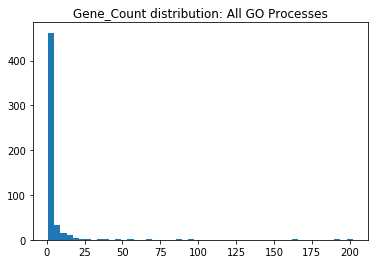

In [6]:
plt.hist(GO['Gene_Count'].values,bins=50)
plt.title('Gene_Count distribution: All GO Processes')

Text(0.5, 1.0, 'Gene_Count distribution: GO Processes not involved in Artemisin Resistance')

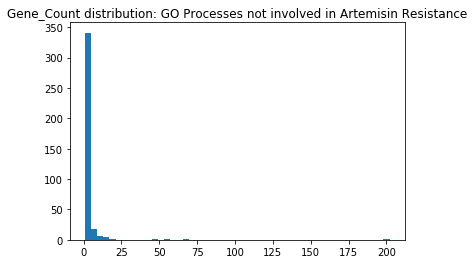

In [7]:
plt.hist(GO[GO['IsInvolvedInArtemisinResistance']==0]['Gene_Count'].values,bins=50)
plt.title('Gene_Count distribution: GO Processes not involved in Artemisin Resistance')

Text(0.5, 1.0, 'Gene_Count distribution: GO Processes involved in Artemisin Resistance')

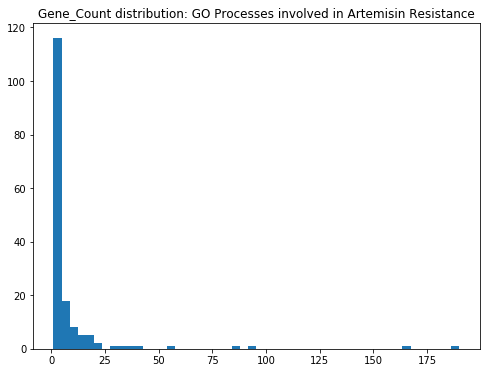

In [8]:
plt.figure(figsize=(8,6))
plt.hist(GO[GO['IsInvolvedInArtemisinResistance']==1]['Gene_Count'].values,bins=50)
plt.title('Gene_Count distribution: GO Processes involved in Artemisin Resistance')

### 2.4 Filter the GO DataFrame

Keep the Go Processes Involved in Artemisin Resistance (IsInvolvedInARtemisinResistance=1) and that Gene_Count <= 25, other wise they can be considered as ubiquituous and generic genes not specific to artemisin resistance.

In [9]:
GO=GO[GO['IsInvolvedInArtemisinResistance']==1].reset_index(drop=True)
GO=GO[GO['Gene_Count']<=25].reset_index(drop=True)

In [56]:
GO.shape

(154, 5)

### 2.5 Create a list of unique genes involved in Artemisin resistance

In [10]:
result = set()
for row in range(len(GO)):
    result = result | set(GO["Gene_ID"][row])
result = list(result)
print("Total of genes including after filtering: {}".format(len(result)))

Total of genes including after filtering: 489


## 3. Format the train DataFrame 


### 3.1 Filter train DataFrame

Keep only the important genes found in previous steps.

In [11]:
important_genes = set(list(train.columns)) & set(result)
important_genes = list(important_genes)
important_genes

['PF3D7_0103100',
 'PF3D7_1113400',
 'PF3D7_0316600',
 'PF3D7_1365400',
 'PF3D7_1332800',
 'PF3D7_0518700',
 'PF3D7_1032500',
 'PF3D7_1364900',
 'PF3D7_0401900',
 'PF3D7_1028300',
 'PF3D7_0621800',
 'PF3D7_1304700',
 'PF3D7_1246200',
 'PF3D7_1342800',
 'PF3D7_1326400',
 'PF3D7_0806400',
 'PF3D7_1432000',
 'PF3D7_0629000',
 'PF3D7_1104100',
 'PF3D7_0109400',
 'PF3D7_1111300',
 'PF3D7_1332000',
 'PF3D7_1015600',
 'PF3D7_1250600',
 'PF3D7_1418100',
 'PF3D7_1434000',
 'PF3D7_1125400',
 'PF3D7_1014000',
 'PF3D7_0311600',
 'PF3D7_1132800',
 'PF3D7_0112000',
 'PF3D7_1129100',
 'PF3D7_0808200',
 'PF3D7_1229100',
 'PF3D7_1477800',
 'PF3D7_1223900',
 'PF3D7_1420900',
 'PF3D7_1420600',
 'PF3D7_1468500',
 'PF3D7_1250100',
 'PF3D7_1449500',
 'PF3D7_0302600',
 'PF3D7_1244800',
 'PF3D7_0831800',
 'PF3D7_0933600',
 'PF3D7_0503400',
 'PF3D7_0413600',
 'PF3D7_1423000',
 'PF3D7_0418500',
 'PF3D7_1145400',
 'PF3D7_0209000',
 'PF3D7_1118100',
 'PF3D7_0528100',
 'PF3D7_0422700',
 'PF3D7_1313000',
 'PF3D7_07

In [12]:
columns_to_keep = list(train.columns)[0:5] + \
[list(train.columns)[-1]] + important_genes
filtered_train = train[columns_to_keep]
filtered_train.head(10)

,Sample_Name,Isolate,Timepoint,Treatment,BioRep,DHA_IC50,PF3D7_0103100,PF3D7_1113400,PF3D7_0316600,PF3D7_1365400,...,PF3D7_1248900,PF3D7_1418000,PF3D7_1145500,PF3D7_0729000,PF3D7_1107700,PF3D7_1455800,PF3D7_0822700,PF3D7_0615100,PF3D7_1368700,PF3D7_1120100
0,isolate_01.24HR.DHA.BRep1,isolate_01,24HR,DHA,BRep1,2.177,0.546388,-1.128355,-1.327534,-0.156837,...,0.301016,-0.952690,0.279339,-1.226982,-0.601264,0.370688,0.052888,1.172914,0.214119,-1.556791
1,isolate_01.24HR.DHA.BRep2,isolate_01,24HR,DHA,BRep2,2.177,0.761318,0.107479,-0.995795,-0.229091,...,-0.369993,0.045607,-0.062262,-0.202022,0.779304,-0.357472,-0.457561,-0.415284,-0.052524,-0.003310
2,isolate_01.24HR.UT.BRep1,isolate_01,24HR,UT,BRep1,2.177,0.457517,0.583398,0.947587,0.320380,...,-0.200694,0.561402,0.119339,-0.747152,0.842797,-1.175463,-0.363938,-1.198974,-0.426401,-0.208977
3,isolate_01.24HR.UT.BRep2,isolate_01,24HR,UT,BRep2,2.177,0.097237,0.187025,-1.500040,-0.475569,...,-0.395173,-0.275397,-0.395711,0.079165,1.018064,-0.851277,-0.379484,-0.615487,-0.138030,0.222214
4,isolate_01.6HR.DHA.BRep1,isolate_01,6HR,DHA,BRep1,2.177,1.480464,0.578201,-1.024420,-0.492496,...,-0.566295,-0.308661,0.959017,0.305574,1.013794,-1.568232,-0.643368,-1.981328,0.984442,0.290645
5,isolate_01.6HR.DHA.BRep2,isolate_01,6HR,DHA,BRep2,2.177,0.531144,-0.066396,-2.082783,-0.474135,...,-0.163990,-0.411470,-0.316264,-0.483181,0.171113,-0.445907,0.141246,-0.294960,-0.162748,-0.304112
6,isolate_01.6HR.UT.BRep1,isolate_01,6HR,UT,BRep1,2.177,0.603536,0.244054,-0.458651,-0.838927,...,-0.413829,0.031298,0.377592,0.189855,1.518686,-0.351670,0.060710,-1.226338,0.285581,0.448905
7,isolate_01.6HR.UT.BRep2,isolate_01,6HR,UT,BRep2,2.177,0.069373,0.521825,-0.676671,-0.312724,...,-0.337458,-0.113089,-0.262237,-0.228684,1.129311,-1.570862,-0.260881,-1.088017,-0.585894,-0.195927
8,isolate_02.24HR.DHA.BRep1,isolate_02,24HR,DHA,BRep1,1.697,0.462983,0.019885,-1.272564,-0.363070,...,-0.435417,-0.181015,-0.065154,-1.029959,0.574004,-0.468242,-0.317749,-0.881073,-0.256736,-0.038126
9,isolate_02.24HR.DHA.BRep2,isolate_02,24HR,DHA,BRep2,1.697,0.044230,0.399496,-1.261550,0.399296,...,-0.218392,-1.014364,0.347310,0.939563,1.101539,-1.554376,0.417378,-1.065045,0.479826,1.466521


In [13]:
aggregated_means_train = filtered_train.groupby(["Isolate","Timepoint","Treatment"]).mean()
aggregated_means_train.head(10)

DHA_IC50  PF3D7_0103100  PF3D7_1113400  \
Isolate    Timepoint Treatment                                           
isolate_01 24HR      DHA           2.177       0.653853      -0.510438   
                     UT            2.177       0.277377       0.385211   
           6HR       DHA           2.177       1.005804       0.255902   
                     UT            2.177       0.336455       0.382939   
isolate_02 24HR      DHA           1.697       0.331136       0.073804   
                     UT            1.697       0.561382      -0.134311   
           6HR       DHA           1.697       0.335395       0.168795   
                     UT            1.697       0.458775      -0.415601   
isolate_03 24HR      DHA           1.799       0.675816       0.223565   
                     UT            1.799       0.646063      -0.590286   

                                PF3D7_0316600  PF3D7_1365400  PF3D7_1332800  \
Isolate    Timepoint Treatment                                                
isolate_01 24HR      DHA            -1.161665      -0.192964       0.068980   
                     UT             -0.276227      -0.077595       0.320080   
           6HR       DHA            -1.553602      -0.483316      -0.307089   
                     UT             -0.567661      -0.575826      -0.081673   
isolate_02 24HR      DHA            -0.718012      -0.148181      -0.012227   
                     UT             -0.995932      -0.383333       0.146802   
           6HR       DHA            -0.818091      -0.504543      -0.114557   
                     UT             -0.789463      -0.432542       0.194308   
isolate_03 24HR      DHA            -1.071164      -0.543314      -0.220015   
                     UT             -0.986307      -0.325104       0.346945   

                                PF3D7_0518700  PF3D7_1032500  PF3D7_1364900  \
Isolate    Timepoint Treatment                                                
isolate_01 24HR      DHA             0.326233      -0.126729      -0.267206   
                     UT              0.507677      -0.375107      -0.094449   
           6HR       DHA            -0.444613      -1.065171      -0.669470   
                     UT              0.202728      -0.554611      -0.101444   
isolate_02 24HR      DHA             0.111122      -0.675144      -0.320044   
                     UT              0.016756      -0.747972      -0.363977   
           6HR       DHA             0.059692      -0.680812      -0.472327   
                     UT              0.091603      -0.735065      -0.584124   
isolate_03 24HR      DHA             0.178888      -0.313872      -0.640004   
                     UT              0.397773      -0.184852      -0.616229   

                                PF3D7_0401900  ...  PF3D7_1248900  \
Isolate    Timepoint Treatment                 ...                  
isolate_01 24HR      DHA             0.492286  ...      -0.034488   
                     UT              0.601081  ...      -0.297934   
           6HR       DHA             0.147631  ...      -0.365143   
                     UT              0.575763  ...      -0.375644   
isolate_02 24HR      DHA             0.605697  ...      -0.279167   
                     UT              1.038584  ...      -0.041029   
           6HR       DHA             0.561975  ...      -0.164848   
                     UT              1.112013  ...      -0.078132   
isolate_03 24HR      DHA             0.438748  ...      -0.306300   
                     UT              0.944834  ...       0.251741   

                                PF3D7_1418000  PF3D7_1145500  PF3D7_0729000  \
Isolate    Timepoint Treatment                                                
isolate_01 24HR      DHA            -0.453542       0.108538      -0.714502   
                     UT              0.143003      -0.138186      -0.333994   
           6HR       DHA            -0.360066       0.321377      -0.088803   
                     

### 3.2 Flatten the aggregated_means_train data frame 

We do this so that each row is an isolate and the different timepoints and treatments become columns.

**Before**
```python

| Isolate  | Timepoint | Treatment | PF3D7_0107600 |
|----------|-----------|-----------|---------------|
|isolate_01|       24Hr|        DHA|         value1|
|          |           |         UT|         value2|
|          |        6Hr|        DHA|         value3|
|          |           |         UT|         value4|
```

**After**
```python

| Isolate  | PF3D7_0107600_24HR_DHA | PF3D7_0107600_24HR_UT | PF3D7_0107600_6HR_DHA | PF3D7_0107600_6HR_UT |
|----------|------------------------|-----------------------|-----------------------|----------------------|
|isolate_01|                  value1|                 value2|                 value3|                value4|
```

In [14]:
gene_dict={}
isolate_comb_list=['_24HR_DHA','_24HR_UT','_6HR_DHA','_6HR_UT']
for gene in important_genes:
    gene_dict[gene]=[gene+comb for comb in isolate_comb_list]
gene_dict

{'PF3D7_0103100': ['PF3D7_0103100_24HR_DHA',
  'PF3D7_0103100_24HR_UT',
  'PF3D7_0103100_6HR_DHA',
  'PF3D7_0103100_6HR_UT'],
 'PF3D7_1113400': ['PF3D7_1113400_24HR_DHA',
  'PF3D7_1113400_24HR_UT',
  'PF3D7_1113400_6HR_DHA',
  'PF3D7_1113400_6HR_UT'],
 'PF3D7_0316600': ['PF3D7_0316600_24HR_DHA',
  'PF3D7_0316600_24HR_UT',
  'PF3D7_0316600_6HR_DHA',
  'PF3D7_0316600_6HR_UT'],
 'PF3D7_1365400': ['PF3D7_1365400_24HR_DHA',
  'PF3D7_1365400_24HR_UT',
  'PF3D7_1365400_6HR_DHA',
  'PF3D7_1365400_6HR_UT'],
 'PF3D7_1332800': ['PF3D7_1332800_24HR_DHA',
  'PF3D7_1332800_24HR_UT',
  'PF3D7_1332800_6HR_DHA',
  'PF3D7_1332800_6HR_UT'],
 'PF3D7_0518700': ['PF3D7_0518700_24HR_DHA',
  'PF3D7_0518700_24HR_UT',
  'PF3D7_0518700_6HR_DHA',
  'PF3D7_0518700_6HR_UT'],
 'PF3D7_1032500': ['PF3D7_1032500_24HR_DHA',
  'PF3D7_1032500_24HR_UT',
  'PF3D7_1032500_6HR_DHA',
  'PF3D7_1032500_6HR_UT'],
 'PF3D7_1364900': ['PF3D7_1364900_24HR_DHA',
  'PF3D7_1364900_24HR_UT',
  'PF3D7_1364900_6HR_DHA',
  'PF3D7_1364900_6H

In [15]:
isolates_list=aggregated_means_train.index.get_level_values(0)
isolates_list=list(dict.fromkeys(isolates_list))
isolates_list

['isolate_01',
 'isolate_02',
 'isolate_03',
 'isolate_04',
 'isolate_05',
 'isolate_06',
 'isolate_07',
 'isolate_08',
 'isolate_09',
 'isolate_10',
 'isolate_11',
 'isolate_12',
 'isolate_13',
 'isolate_14',
 'isolate_15',
 'isolate_16',
 'isolate_17',
 'isolate_18',
 'isolate_19',
 'isolate_20',
 'isolate_21',
 'isolate_22',
 'isolate_23',
 'isolate_24',
 'isolate_25',
 'isolate_26',
 'isolate_27',
 'isolate_28',
 'isolate_29',
 'isolate_30']

In [16]:
flat_train=pd.DataFrame()
genes=[]
for gene in important_genes:
    temp_list=[]
    for isolate in isolates_list:
        temp_list.append(aggregated_means_train.loc[isolate][gene].tolist())
    flat_train=pd.concat([flat_train,pd.DataFrame(data=temp_list,columns=gene_dict[gene])],axis=1)

flat_train.index=isolates_list
flat_train.head(10)

,PF3D7_0103100_24HR_DHA,PF3D7_0103100_24HR_UT,PF3D7_0103100_6HR_DHA,PF3D7_0103100_6HR_UT,PF3D7_1113400_24HR_DHA,PF3D7_1113400_24HR_UT,PF3D7_1113400_6HR_DHA,PF3D7_1113400_6HR_UT,PF3D7_0316600_24HR_DHA,PF3D7_0316600_24HR_UT,...,PF3D7_0615100_6HR_DHA,PF3D7_0615100_6HR_UT,PF3D7_1368700_24HR_DHA,PF3D7_1368700_24HR_UT,PF3D7_1368700_6HR_DHA,PF3D7_1368700_6HR_UT,PF3D7_1120100_24HR_DHA,PF3D7_1120100_24HR_UT,PF3D7_1120100_6HR_DHA,PF3D7_1120100_6HR_UT
isolate_01,0.653853,0.277377,1.005804,0.336455,-0.510438,0.385211,0.255902,0.382939,-1.161665,-0.276227,...,-1.138144,-1.157177,0.080798,-0.282215,0.410847,-0.150157,-0.780051,0.006618,-0.006733,0.126489
isolate_02,0.331136,0.561382,0.335395,0.458775,0.073804,-0.134311,0.168795,-0.415601,-0.718012,-0.995932,...,-0.639042,-0.257416,-0.089342,-0.146143,-0.252670,-0.444497,0.408263,-0.122310,-0.220754,-0.084718
isolate_03,0.675816,0.646063,0.491280,0.736209,0.223565,-0.590286,0.646445,-1.129728,-1.071164,-0.986307,...,-1.424975,0.251394,0.727760,0.133737,0.326819,-0.004934,-0.027882,-0.820471,0.070535,-0.519574
isolate_04,0.200649,0.609131,0.628377,0.670965,0.138810,0.027986,0.085633,-0.135172,-1.034470,-0.003506,...,-0.606306,-0.992712,-0.340095,-0.419907,-0.080155,-0.227690,-0.432537,0.367170,-0.286565,-0.478585
isolate_05,0.558002,0.897172,0.572906,0.150061,0.206363,-0.761567,-0.335874,0.399728,0.133440,-1.659505,...,-0.657011,-1.267131,0.233692,-0.417693,-0.229486,-0.242656,0.124827,-0.510642,-0.060512,0.112000
isolate_06,0.345731,0.498942,0.635469,0.282293,-0.047701,0.316469,0.760935,-0.122704,-1.081895,-0.933396,...,-1.332157,-0.443450,-0.440766,-0.173868,0.486999,-0.171717,0.283084,-0.664917,0.352402,0.095570
isolate_07,0.458958,0.678585,0.593666,0.278621,-0.124725,0.522536,0.290042,0.004767,-0.687664,-1.112435,...,-0.867370,-1.048168,-0.146803,0.370305,0.407293,-0.525066,0.254137,0.107530,-0.451243,0.222803
isolate_08,0.272211,0.676355,0.667278,0.612478,0.214352,0.694909,-0.152980,-0.090538,0.015289,-0.077563,...,-0.677848,-0.821441,0.019653,0.124482,-0.151279,-0.423897,0.304378,-0.263471,-0.698105,-0.161987
isolate_09,0.681638,0.308265,0.704306,0.421292,0.233309,0.107963,-0.651370,0.247360,-0.453652,0.232051,...,-0.409313,-0.507110,0.118065,-0.857927,0.379096,-0.276595,-0.236835,0.437420,-0.823221,0.170604
isolate_10,0.951690,0.495587,0.685627,0.379364,-0.004684,0.323114,0.136315,-0.311553,-1.283263,-0.079170,...,-1.127675,0.190471,-0.091839,-0.523693,-0.265257,-0.140997,-0.544387,0.137648,0.060187,-0.096696


## 3. Train the model using Kernel Ridge Regression

### 3.1 Select val_isolates

Given that the range of the IC50 of the 30 isolates was wide and there were too few sample points, we decide to select an isolate that would represente every group of 5 of the isolates sorted in ascending order, to make sure the validation set was a good representation of the whole isolates set. 

These were the selected isolates:
* isolate_07
* isolate_27
* isolate_18
* isolate_11
* isolate_16

In [17]:
val_isolates=['isolate_07','isolate_11','isolate_16','isolate_18','isolate_27']

### 3.2 Create helper functions

In [18]:
def getGenesColumnLabels(genes):
#Takes a list of genes and returns the genes labels
    genes_list=[]
    for gene in genes:
        genes_list=genes_list+list(genes_column_labels_df[gene][0:4])
    return genes_list

In [19]:
def findTrainIsolates(val_isolates,df):
#Takes a list of isolates chosen to be the validation set and the train df.
#Returns the isolates not in val_isolates
    train_isolates=list(set(df.index)-set(val_isolates))
    train_isolates.sort()
    return train_isolates

In [20]:
def filterDfByIsolates(isolates,df):
#Takes a list of isolates and a dataframe
#Returns the rows of the dataframe whose index are in isolates
    filtered_df=df.loc[isolates]
    return filtered_df

In [21]:
def filterDfByGenes(genes,df):
#Takes a list of genes e.g.['PF3D7_1360200','PF3D7_1212800'] and a dataframe
#Returns the columns of the dataframe whose labels are in genes
    genes_to_filter=getGenesColumnLabels(genes)
    filtered_df=df[genes_to_filter]
    return filtered_df

In [22]:
def trainModelKRR(genes,val_isolates,dfx,dfy):
# Takes a list of genes to include in the model, a list of validation isolates, a X dataframe and a y dataframe
# Returns the score of the model. The score is R^2. 
    train_isolates=findTrainIsolates(val_isolates,dfx)
    
    X=filterDfByIsolates(train_isolates,dfx)
    X=filterDfByGenes(genes,X)
    
    y=filterDfByIsolates(train_isolates,dfy)
    
    model=KernelRidge(alpha=1)
    model=model.fit(X.values,y.values)
    
    X_val=filterDfByIsolates(val_isolates,dfx)
    X_val=filterDfByGenes(genes,X_val)
    
    y_val=filterDfByIsolates(val_isolates,dfy).values
    
    score=model.score(X_val,y_val)
    
    return score

### 3.3 Find group of genes that improve the model's score

To find the genes that improved the model's score the model was trained multiple times, following these steps:

1. The first time, the model was trained with only one gen at a time and then the gene that yielded the best score was selected.

2. The second time, the model was trained with a pair of genes at a time. The pair of genes consisted on the gene found in the previous round plus another gene from the list that was left.

3. This loop was ran 100 times, every time the model was trained the set of selected genes consisted on the previous genes found to generate the best score plus a new gene.

In [23]:
selected_genes=[]
selected_scores=[0]
N=100
for i in range(N):
    best_gene_so_far=''
    best_score_so_far=selected_scores[-1]
    
    for gene in important_genes:
        
        if gene not in selected_genes:
            genes_to_use=selected_genes+[gene]
            
            model_score=trainModelKRR(genes_to_use,val_isolates,flat_train,IC50)
            
            if model_score > best_score_so_far:
                best_score_so_far=model_score
                best_gene_so_far=gene

    
    if best_score_so_far>selected_scores[-1]:
        selected_genes.append(best_gene_so_far)
        selected_scores.append(best_score_so_far)

In [24]:
selected_scores

[0,
 0.7318566233529242,
 0.9297983051256823,
 0.9831740698897834,
 0.9940061650116655,
 0.9943657718503077,
 0.996428642182933]

<function matplotlib.pyplot.show(*args, **kw)>

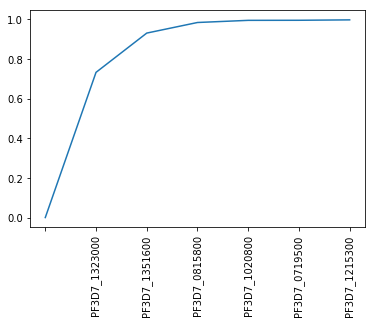

In [25]:
x=np.arange(len(selected_scores))
y=selected_scores
plt.plot(x,y)
plt.xticks(x,['']+selected_genes,rotation='vertical')
plt.show

As it can be seen, after training the model multiple times, the first four genes were found to be necesary to reach a good score. Therefore, these genes were selected to train the model again with all the isolates.

### 3.4 Try the model with the selected genes

In [37]:
selected_genes=selected_genes[0:4]
selected_genes

['PF3D7_1323000', 'PF3D7_1362200', 'PF3D7_1329100', 'PF3D7_0818900']

In [38]:
def tryModel(genes,val_isolates,dfx,dfy):
    model_info={}
    
    train_isolates=findTrainIsolates(val_isolates,dfx)
    
    X=filterDfByIsolates(train_isolates,dfx)
    X=filterDfByGenes(genes,X)
    
    y=filterDfByIsolates(train_isolates,dfy)
    
    model=KernelRidge(alpha=1)
    model=model.fit(X.values,y.values)
    
    X_val=filterDfByIsolates(val_isolates,dfx)
    X_val=filterDfByGenes(genes,X_val)
    
    y_val=filterDfByIsolates(val_isolates,dfy).values
    
    y_pred=model.predict(X_val)
    
    score=model.score(X_val,y_val)
    
    model_info['y']=y.values
    model_info['y_val']=y_val
    model_info['X']=X.values
    model_info['X_val']=X_val
    model_info['y_pred']=y_pred
    model_info['score']=score
    return model_info

In [39]:
try_model=tryModel(selected_genes,val_isolates,flat_train,IC50)
y=[try_model['y_val'][i][0] for i in range(len(try_model['y_val']))]
y_pred=try_model['y_pred']

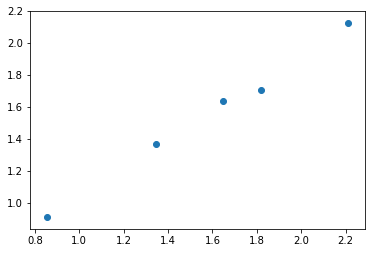

In [40]:
plt.scatter(y,y_pred)

### 3.5 Train the model with all the isolates and only the selected genes

In [41]:
X=flat_train[getGenesColumnLabels(selected_genes)]
X_test=test[getGenesColumnLabels(selected_genes)]
y=IC50

In [42]:
model=KernelRidge(alpha=1)
model=model.fit(X.values,y.values)

In [43]:
X.shape

(30, 16)

In [44]:
X_test.shape

(25, 16)

## 4. Make the IC50 predictions

In [51]:
IC50_pred=model.predict(X_test)

### 4.1 Format predictions

In [55]:
temp_list=[]
for value in IC50_pred:
    temp_list.append(value[0])
IC50_pred=temp_list
submission=pd.DataFrame({'Isolate':isolates_test,'Predicted_IC50':IC50_pred})
submission.head()

,Isolate,Predicted_IC50
0,isolate_31,1.009405
1,isolate_32,1.267505
2,isolate_33,0.933033
3,isolate_34,1.256865
4,isolate_35,0.345308
